# Mutual Information Neural Estimator
https://arxiv.org/pdf/1801.04062.pdf

# Part 1
from https://github.com/MasanoriYamada/Mine_pytorch

In [0]:
# http://pytorch.org/
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision
import torch

In [0]:
!pip install holoviews
!pip install bokeh
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import holoviews as hv
import bokeh
import numpy as np
hv.extension('bokeh')

In [0]:
import numpy as np
# data
var = 0.2
n = 10 #DIM

def func(x):
  return x

def gen_x():
  return np.sign(np.random.normal(0.,1.,[data_size,1]))

def gen_xx():
  return np.random.normal(np.zeros(n), np.ones(1), [data_size,n])
def gen_yy(x):
  return x + np.random.normal(np.zeros(n), np.ones(n)*np.sqrt(var), [data_size,n])

def gen_y(x):
  return func(x)+np.random.normal(0.,np.sqrt(var),[data_size,1])

In [0]:
!git clone https://github.com/gregversteeg/NPEET.git
%cd NPEET/npeet
!ls
import entropy_estimators as ee

data_size = 20000
x=gen_xx()
y=gen_yy(x)
'''p_y_x=np.exp(-(y-x)**2/(2*var))
p_y_x_minus=np.exp(-(y+1)**2/(2*var))
p_y_x_plus=np.exp(-(y-1)**2/(2*var))
mi=np.average(np.log(p_y_x/(0.5*p_y_x_minus+0.5*p_y_x_plus)))'''
mi = ee.mi(x,y)
print(mi)

In [97]:
H=10
n_epoch = 500
data_size = 20000

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1, H)
        self.fc2 = nn.Linear(1, H)
        self.fc3 = nn.Linear(H, 1)

    def forward(self, x, y):
        h1 = F.relu(self.fc1(x)+self.fc2(y))
        h2 = self.fc3(h1)
        return h2    

model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []
for epoch in tqdm(range(n_epoch)):
    x_sample=gen_x()
    y_sample=gen_y(x_sample)
    y_shuffle=np.random.permutation(y_sample)
    
    x_sample = Variable(torch.from_numpy(x_sample).type(torch.FloatTensor), requires_grad = True)
    y_sample = Variable(torch.from_numpy(y_sample).type(torch.FloatTensor), requires_grad = True)
    y_shuffle = Variable(torch.from_numpy(y_shuffle).type(torch.FloatTensor), requires_grad = True)    
    
    pred_xy = model(x_sample, y_sample)
    pred_x_y = model(x_sample, y_shuffle)

    ret = torch.mean(pred_xy) - torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = - ret  # maximize
    plot_loss.append(loss.data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

100%|██████████| 500/500 [00:17<00:00, 27.78it/s]


In [0]:
import tensorflow as tf
epochs = 500
S = 512 #Size of the linear activation output
data_size = 20000
plot_loss = []
g_1 = tf.Graph()
with g_1.as_default():
    #Build the graph
    x = tf.placeholder(dtype=tf.float32, shape=(data_size,n))
    t = tf.placeholder(dtype=tf.float32, shape=(data_size,n))
    t_shuffled = tf.placeholder(dtype=tf.float32, shape=(data_size,n))


    t_shuffled = tf.random_shuffle(t)

    #Architecture for MNIST from the paper: Gaussian(0.3) -> ELU -> Gaussian(0.5) -> ELU -> Gaus(0.5) -> Dense(1)

    def forward(x,t):
      with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        fc1 = tf.layers.dense(x, S) #Linear activation for both
        fc2 = tf.layers.dense(t, S)
        fc22 = tf.add(tf.add(fc1,fc2), tf.random_normal(shape=tf.shape(fc1), stddev=0.3))
        fc3 = tf.layers.dense(fc22, S, activation='elu')
        #fc3 = tf.layers.batch_normalization(fc3)
        fc33 = tf.add(fc3, tf.random_normal(shape=tf.shape(fc3), stddev=0.5))
        fc4 = tf.layers.dense(fc33, S, activation='elu')
        #fc4 = tf.layers.batch_normalization(fc4)
        fc44 = tf.add(fc4, tf.random_normal(shape=tf.shape(fc4), stddev=0.5))
        fc5 = tf.layers.dense(fc44,1) #Output
        return fc4

    pred_xy = forward(x, t)
    pred_x_y = forward(x, t_shuffled)

    ret = tf.reduce_mean(pred_xy) - tf.log(tf.reduce_mean(tf.exp(pred_x_y)))
    loss = - ret
    optimizer = tf.train.AdamOptimizer(0.0001).minimize(loss)

    sess_1 = tf.Session(graph = g_1)

    train_writer = tf.summary.FileWriter('./log', sess_1.graph)
    
    sess_1.run(tf.global_variables_initializer()) # initialization
    for epoch_n in range(epochs):
      x_sample = gen_xx()
      y_sample = gen_yy(x_sample)
      _, l = sess_1.run([optimizer, loss], feed_dict={x:x_sample, t: y_sample})
      plot_loss.append(l)
      
    sess_1.close()

In [0]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip

In [64]:
LOG_DIR = './log'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6006 &'
    .format(LOG_DIR)
)
get_ipython().system_raw('./ngrok http 6006 &')
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://cdbe34d5.ngrok.io


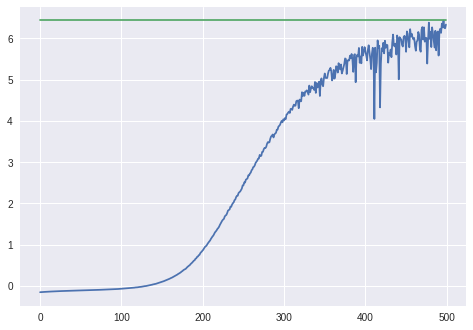

In [90]:
plot_x = np.arange(len(plot_loss))
plot_y = np.array(plot_loss).reshape(-1,)

import matplotlib.pyplot as plt
plt.plot(plot_x, -plot_y)
plt.plot(plot_x, mi*np.ones(len(plot_loss)))
plt.show()

# Part 2
Using this measure for the toy example used in Tishby's paper
https://arxiv.org/abs/1703.00810

In [0]:
import numpy as np
from random import randint, seed


n_train_samples = 50000 # number of train samples
n_test_samples = 10000 # number of test samples

groups = np.append(np.zeros(8),np.ones(8)) # 16 groups
np.random.seed(1234)
np.random.shuffle(groups)

# generate samples
seed(1234)
def generate_samples(n_samples):
    x_data = np.zeros((n_samples, 10)) # inputs
    x_int = np.zeros(n_samples) # integers representing the inputs
    y_data = np.zeros((n_samples, 2)) # outputs
    
    for i in range(n_samples):
        random_int = randint(0, 1023)
        x_data[i,:] = [int(b) for b in list("{0:b}".format(random_int).zfill(10))]
        x_int[i] = random_int
        y_data[i,0] = groups[random_int % 16]
        y_data[i,1] = 1 - y_data[i,0]
        
    return x_data, y_data, x_int

x_train, y_train, x_train_int = generate_samples(n_train_samples) # training dataset
x_test, y_test, _ = generate_samples(n_test_samples) # testing dataset

In [0]:
import tensorflow as tf


  
def fully_conn(tensor, n_outputs, name):
    size = tensor.get_shape().as_list()[1]

    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))

    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)

    # hyperbolic tangent activation
    tensor = tf.tanh(tensor, name=name)

    return tensor



def output(tensor, n_outputs):
    size = tensor.get_shape().as_list()[1]

    # weight and bias tensor
    weight = tf.Variable(tf.truncated_normal([size, n_outputs]))
    bias = tf.Variable(tf.zeros([n_outputs]))

    # fully-connected layer
    tensor = tf.matmul(tensor, weight)
    bias = tf.nn.bias_add(tensor, bias)

    return tensor


def mlp(x, n_neurons): # x is the input layer    
    # hidden layers
    hidden = x
    for n in range(len(n_neurons)):
        hidden = fully_conn(hidden, n_neurons[n], 'hidden%s' % (n+1))

    # output layer
    y = output(hidden, 2)

    return y


def build_network(hidden_layer_neurons):
    global x, y, logits, cost, optimizer, accuracy, g_0

    g_0 = tf.Graph()
    with g_0.as_default() as g0:

      x = tf.placeholder(tf.float32, (None, 10), name='x')
      y = tf.placeholder(tf.float32, (None, 2), name='y')

      tf.set_random_seed(12345)
      logits = mlp(x, hidden_layer_neurons)
      logits = tf.identity(logits, name='logits')

      # cross-entropy coss function
      cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y), name='cost')

      # optimizer
      optimizer = tf.train.GradientDescentOptimizer(0.1).minimize(cost)
      
      assert optimizer.graph is g_0
      # accuracy
      correct_predictions = tf.equal(tf.argmax(logits, 1), tf.argmax(y, 1))
      accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')


def print_out_summary(sess, epoch):
    acc, loss = sess.run([accuracy, cost], feed_dict={x: x_test, y: y_test})
    print('Epoch {:>4}:  Testing accuracy {:>.4f} - Testing loss {:>.4f}'.format(epoch, acc, loss))


In [0]:
import time
import os

def calc_mutual_information(hidden,layer_idx):
  t0 = time.time()
  #Train two MINE's. One for I(X,T) and one for I(T,Y)
  #X: x_train, y: y_train, hidden.shape = 50 000 x number_neurons
  
  #Start with the one for I(X,T)
  
  #Create a different graph in tensorflow
  epochs = 50
  c = str(layer_idx)
  
  batch_size = x_train.shape[0]
  S = 32 #Size of the linear activation output
  pretraining = 200

  g_1 = tf.Graph()
  with g_1.as_default():
    
    #Build the graph
    x = tf.placeholder(dtype=tf.float32, shape=(x_train.shape[1],))
    t = tf.placeholder(dtype=tf.float32, shape=(hidden.shape[1],))
    t_shuffled = tf.placeholder(dtype=tf.float32, shape=(hidden.shape[1],))
    
    #Prepare a tensorflow dataset
    ds = tf.data.Dataset.from_tensor_slices((x_train, hidden))    
    ds = ds.shuffle(buffer_size=10, reshuffle_each_iteration=True).batch(batch_size=batch_size, drop_remainder=True).repeat()
    
    iter = ds.make_one_shot_iterator()
    next = iter.get_next()

    x = tf.cast(next[0], dtype=tf.float32)
    t = next[1]
    t_shuffled = tf.random_shuffle(t)
    

    def forward(xx,tt):
      with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        fc1 = tf.layers.dense(xx, S) #Linear activation for both
        fc2 = tf.layers.dense(tt, S)
        fc3 = tf.nn.relu(tf.add(fc1,fc2))
        fc4 = tf.layers.dense(fc3,1) #Output
        return fc4

    pred_xy = forward(x,t)
    pred_x_y = forward(x,t_shuffled)

    ret = tf.reduce_mean(pred_xy) - tf.log(tf.reduce_mean(tf.exp(pred_x_y)))
    loss = - ret
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

    saver = tf.train.Saver()
    sess_1 = tf.Session(graph = g_1)
    
    
    i_iter = 0
    ckpt = tf.train.get_checkpoint_state(c + '_checkpoints_g_1/')
    if ckpt and ckpt.model_checkpoint_path:
      #print("Found checkpont! Restore...")
      saver.restore(sess_1, ckpt.model_checkpoint_path)
      epoch_n = int(ckpt.model_checkpoint_path.split('-')[1])
      i_iter = epoch_n+1
      #print("Restored Epoch %s" % epoch_n)
    else:
      #print("No chekpoint, initialize variables...")
      if not os.path.exists(c + '_checkpoints_g_1'):
        os.makedirs(c + '_checkpoints_g_1')
      sess_1.run(tf.global_variables_initializer()) # initialization
      #print(sess_1.run(tf.report_uninitialized_variables()))
    
    
    for epoch_n in range(i_iter,epochs):
      #for i in range(int(x_train.shape[0] / batch_size)):
      sess_1.run(optimizer)
      if epoch_n == pretraining: #Save a checkpoint
        saver.save(sess_1, c + '_checkpoints_g_1/model.ckpt', epoch_n)
        #print("Saved model.")
        #if (epoch_n+1) % 20 == 0: print(sess_1.run(ret))
    
    mi_xt = sess_1.run(ret)
    #print("I(X,T): %s" % mi_xt)
    sess_1.close()
    
    
  g_2 = tf.Graph()
  with g_2.as_default():

    #Build the graph
    t = tf.placeholder(dtype=tf.float32, shape=(hidden.shape[1],))
    y = tf.placeholder(dtype=tf.float32, shape=(y_train.shape[1],))
    y_shuffled = tf.placeholder(dtype=tf.float32, shape=(y_train.shape[1],))

    #Prepare a tensorflow dataset
    ds = tf.data.Dataset.from_tensor_slices((hidden, y_train))    
    ds = ds.shuffle(buffer_size=10, reshuffle_each_iteration=True).batch(batch_size=batch_size, drop_remainder=True).repeat()

    iter = ds.make_one_shot_iterator()
    next = iter.get_next()

    t = tf.cast(next[0], dtype=tf.float32)
    y = tf.cast(next[1], dtype=tf.float32)
    y_shuffled = tf.random_shuffle(y)


    def forward(xx,tt):
      with tf.variable_scope('model', reuse=tf.AUTO_REUSE):
        fc1 = tf.layers.dense(xx, S) #Linear activation for both
        fc2 = tf.layers.dense(tt, S)
        fc3 = tf.nn.relu(tf.add(fc1,fc2))
        fc4 = tf.layers.dense(fc3,1) #Output
        return fc4

    pred_xy = forward(t,y)
    pred_x_y = forward(t,y_shuffled)

    ret = tf.reduce_mean(pred_xy) - tf.log(tf.reduce_mean(tf.exp(pred_x_y)))
    loss = - ret
    optimizer = tf.train.AdamOptimizer(0.01).minimize(loss)

    saver = tf.train.Saver()
    sess_2 = tf.Session(graph = g_2)

    
    i_iter = 0
    ckpt = tf.train.get_checkpoint_state(c + '_checkpoints_g_2/')
    if ckpt and ckpt.model_checkpoint_path:
      print("Found checkpont! Restore...")
      saver.restore(sess_2, ckpt.model_checkpoint_path)
      epoch_n = int(ckpt.model_checkpoint_path.split('-')[1])
      i_iter = epoch_n+1
      print("Restored Epoch %s" % epoch_n)
    else:
      print("No chekpoint, initialize variables...")
      if not os.path.exists(c + '_checkpoints_g_2'):
        os.makedirs(c + '_checkpoints_g_2')
      sess_2.run(tf.global_variables_initializer()) # initialization
      print(sess_2.run(tf.report_uninitialized_variables()))
      
    
    for epoch_n in range(i_iter,epochs):
      #for i in range(int(hidden.shape[0] / batch_size)):
      sess_2.run(optimizer)
      if epoch_n == pretraining:  
        saver.save(sess_2, c + '_checkpoints_g_2/model.ckpt', epoch_n)
        print("Saved model.")
      
      
    mi_ty = sess_2.run(ret)    
    #print("I(T,Y): %s" % mi_ty)
    sess_2.close()
  t1 = time.time()
  print("Elapsed time: %s " % (t1-t0))
    
  return mi_xt,mi_ty

    
# get mutual information for all hidden layers
def get_mutual_information(hiddens):
    mi_xt_list = []; mi_ty_list = []
    layers = len(hiddens)
    for idx, hidden in enumerate(hiddens):
        mi_xt, mi_ty = calc_mutual_information(hidden, idx)
        mi_xt_list.append(mi_xt)
        mi_ty_list.append(mi_ty)
    return mi_xt_list, mi_ty_list

In [0]:
def get_hidden_layers(names):
    hidden_layers = []
    for name in names:
        hidden_layers.append(tf.get_default_graph().get_tensor_by_name("%s:0" % name))
    return hidden_layers

# train the neural network and obtain mutual information
def train_with_mi(n_epochs, n_hidden_layers):
  mi_xt_all = []; mi_ty_all = []; epochs = []

  sess_0 = tf.Session(graph=g_0)
  assert sess_0.graph is g_0
  

  with g_0.as_default():
    assert tf.get_default_graph() is g_0
    sess_0.run(tf.global_variables_initializer()) # initialization
    
    hidden_layer_names = ['hidden%s' % i for i in range(1,n_hidden_layers+1)]
    for epoch in range(n_epochs):
        _, hidden_layers = sess_0.run([optimizer,
                                     get_hidden_layers(hidden_layer_names)],
                                     feed_dict={x: x_train, y: y_train})

        if epoch % 100 == 0: print_out_summary(sess_0, epoch)

        if epoch % 50 == 0:
            mi_xt, mi_ty = get_mutual_information(hidden_layers)
            mi_xt_all.append(mi_xt)
            mi_ty_all.append(mi_ty)
            epochs.append(epoch)
            
    sess_0.close()

  return np.array(mi_xt_all), np.array(mi_ty_all), np.array(epochs)

n_epochs = 3000
n_hidden_layers = 3
build_network([8,6,4])
mi_xt_all, mi_ty_all, epochs = train_with_mi(n_epochs, n_hidden_layers)

In [0]:
def delete_checkpoints(n_layers):
  import shutil
  import os
  for layer_id in range(n_layers):
    c = str(layer_id)
    if os.path.exists(c + '_checkpoints_g_1/') and os.path.isdir(c + '_checkpoints_g_1/'):
        shutil.rmtree(c + '_checkpoints_g_1/')
    if os.path.exists(c + '_checkpoints_g_2/') and os.path.isdir(c + '_checkpoints_g_2/'):
        shutil.rmtree(c + '_checkpoints_g_2/')
        
        
delete_checkpoints(3)

In [101]:

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib import animation, rc
from IPython.display import HTML

fig, ax = plt.subplots(figsize=(8,8))
ax.set_xlim((0,11))
ax.set_ylim((0.9,1.1))
ax.set_xlabel('I(X;T)')
ax.set_ylabel('I(T;Y)')
title = ax.set_title('')
plt.close(fig)


cmap = plt.cm.get_cmap('cool')

def animate(i):
    title.set_text('Epoch %s' % str(epochs[i]).zfill(4))
    ax.plot(mi_xt_all[i,:], mi_ty_all[i,:], 'k-',alpha=0.2)
    if i > 0:
        for j in range(n_hidden_layers):
            ax.plot(mi_xt_all[(i-1):(i+1),j],mi_ty_all[(i-1):(i+1),j],'.-',c=cmap(j*.2),ms=10)
    return

anim = animation.FuncAnimation(fig,
                               animate,
                               init_func=None,
                               frames=len(epochs),
                               interval=100)

rc('animation', html='jshtml')
anim

#ax.set_title('Epoch 0000 - 2999')
#fig # show full evolution process

# Save to Google Drive

In [15]:
#Mount Google drive
from google.colab import drive
drive.mount('/content/gdrive')
with open("/content/gdrive/My Drive/colab/MI/mi_xt.npy", 'bw') as outfile:
        np.save(outfile, mi_xt_all)
    
with open("/content/gdrive/My Drive/colab/MI/mi_ty.npy", 'bw') as outfile:
        np.save(outfile, mi_ty_all)
    

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
